In [261]:
import numpy as np
import tensorflow as tf
import time
import math
import matplotlib.pyplot as plt
import seaborn as sns  # for nicer graphics
from sklearn.model_selection import train_test_split
from planet import planet

In [262]:
# Function to split real and imaginary part of complex data into individual element of an array
def split_complex_data(data):
    split_data = np.zeros([data.shape[0],2*data.shape[1]])
    for i in range(data.shape[1]):
        split_data[:,2*i] = data[:,i].real
        split_data[:,2*i+1] = data[:,i].imag
    return split_data

# Function to split testing data according the type of tissue
def split_t2_tissues(data):
    csf_test = [] # T2 = 1.99
    gm_test = []  # T2 = 0.1
    wm_test = []  # T2 = 0.08

    for i in range(len(data)):
        if gt_test[i] == 1.99:
            csf_test.append(data[i,:])

        if gt_test[i] == 0.1:
            gm_test.append(data[i,:])
        
        if gt_test[i] == 0.08:
            wm_test.append(data[i,:])

    csf_test = np.asarray(csf_test)
    gm_test  = np.asarray(gm_test)
    wm_test  = np.asarray(wm_test)
    return csf_test, gm_test, wm_test

# Function for Monte Carlo Simulation
def monte_carlo(data):
    pdf = [] #empty list to store probability value
    result = 0

    # Neural network
    if data.shape[1] == 12:
        predicted_t2 = model.predict(data)

    # PLANET
    if data.shape[1] == 6:
        predicted_t2 = []
        TR = 3e-3 # TR = relaxation time
        npcs = 6  # npcs = no. of phase cycles, 
        B0 = 3   # B0 =main magnetic field
        alpha = np.deg2rad(30) # alpha = flip angle
        pcs = np.linspace(0, 2*np.pi, npcs, endpoint=False)
        for i in range(len(data)):
            _, _,temp = planet(data[i,:], alpha=alpha, TR=TR, T1_guess=2, pcs=pcs, compute_df=False)
            predicted_t2.append(temp)
            
        predicted_t2  = np.asarray(predicted_t2)
    # for i in range(len(predicted_t2)):
    #     result = result + predicted_t2[i]
    #     pdf.append(result/(i+1)) #append result of each iteration to the empty list

    #pdf  = np.asarray(pdf)

    return predicted_t2.mean(), predicted_t2.std(), predicted_t2

In [263]:
# Load voxel and ground truth t2 data
voxel_data = np.load('voxel_data.npy')
gt_data = np.load('gt_data.npy')

# Split training and test set, 1%
# test_size = 1000
# voxel_test = voxel_train[-test_size:, :]
# gt_test = gt_train[-test_size:,:]
# voxel_train = voxel_train[:-test_size,:]
# gt_train = gt_train[:-test_size,:]
voxel_train, voxel_test, gt_train, gt_test = train_test_split(voxel_data, gt_data, test_size=0.1, random_state=42)

print('Training data:', voxel_train[0,:])
print('Ground Truth T2:', gt_train[0,:])

Training data: [-0.02698599+0.00662507j  0.10293612+0.06494154j  0.07334723+0.13095324j
 -0.00014872+0.14816572j -0.07384466+0.13044186j -0.1181152 +0.07258951j]
Ground Truth T2: [0.08]


In [264]:
new_voxel_train = split_complex_data(voxel_train)
print('Complex voxel data split into real and imaginary parts:')
print(new_voxel_train[0,:])
new_voxel_test = split_complex_data(voxel_test)

Complex voxel data split into real and imaginary parts:
[-0.02698599  0.00662507  0.10293612  0.06494154  0.07334723  0.13095324
 -0.00014872  0.14816572 -0.07384466  0.13044186 -0.1181152   0.07258951]


In [265]:
# Define the network structure
inputs = tf.keras.Input(shape=(12,)) #number of inputs
x = tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, kernel_initializer='he_uniform',bias_initializer=tf.keras.initializers.Constant(0.01))(inputs)
x = tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, kernel_initializer='he_uniform',bias_initializer=tf.keras.initializers.Constant(0.01))(x)
x = tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, kernel_initializer='he_uniform',bias_initializer=tf.keras.initializers.Constant(0.01))(x)
x = tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, kernel_initializer='he_uniform',bias_initializer=tf.keras.initializers.Constant(0.01))(x)
x = tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, kernel_initializer='he_uniform',bias_initializer=tf.keras.initializers.Constant(0.01))(x)
x = tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, kernel_initializer='he_uniform',bias_initializer=tf.keras.initializers.Constant(0.01))(x)
outputs = tf.keras.layers.Dense(1, activation=tf.keras.activations.linear, kernel_initializer='he_uniform',bias_initializer=tf.keras.initializers.Constant(0.01))(x) # no. of outputs
#outputs=tf.keras.layers.Dense(1, activation=tf.keras.activations.relu, kernel_initializer='normal',bias_initializer=tf.keras.initializers.Constant(0.1))(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [266]:
# Define optimizer and train the network

# To save the model for each epoch, uncomment the checkpoint_callback below
# checkpoint_callback=tf.keras.callbacks.ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=True mode='auto', save_freq='epoch')

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt, loss='mse', metrics='mse')

start=time.time()

history = model.fit(new_voxel_train, gt_train,epochs=10, batch_size=10, validation_split=0.1)  # starts training

# 2nd set of parameters
# model.fit(voxel_train, gt_train,epochs=100, batch_size=100, validation_data=(voxel_valid,gt_valid),callbacks=[checkpoint_callback])  # starts training

end=time.time()
print('Time Elapsed:%i seconds'%(end-start))

Epoch 1/10
810/810 [==============================] - 4s 5ms/step - loss: 0.0490 - mse: 0.0490 - val_loss: 0.0063 - val_mse: 0.0063
Epoch 2/10
810/810 [==============================] - 4s 5ms/step - loss: 0.0094 - mse: 0.0094 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 3/10
810/810 [==============================] - 6s 7ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 4/10
810/810 [==============================] - 5s 7ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 5.0573e-04 - val_mse: 5.0573e-04
Epoch 5/10
810/810 [==============================] - 4s 5ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 3.1017e-04 - val_mse: 3.1017e-04
Epoch 6/10
810/810 [==============================] - 4s 5ms/step - loss: 6.4993e-04 - mse: 6.4993e-04 - val_loss: 2.8691e-04 - val_mse: 2.8691e-04
Epoch 7/10
810/810 [==============================] - 4s 5ms/step - loss: 0.0078 - mse: 0.0078 - val_loss: 1.5040e-04 - val_mse: 1.5040e-04
Epoch 8/10
810/810 [================

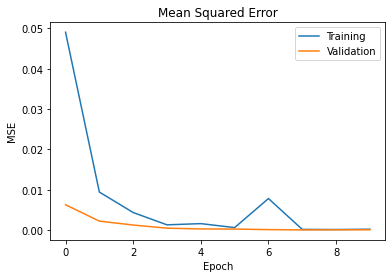

100/100 [==============================] - 0s 2ms/step - loss: 1.2048e-04 - mse: 1.2048e-04
Test MSE:0.000120


In [267]:
# MSE for each epoch during training
#print(model.summary())
#print(history.history.keys())
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Mean Squared Error')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# Evaluate model using testing set
test_metric = model.evaluate(new_voxel_test, gt_test, batch_size=10)
print('Test MSE:%.6f'%test_metric[1])

In [268]:
# Save or load trained model 
model.save('voxel_regression'); 
#model = tf.keras.models.load_model('voxel_regression')

In [269]:
# Split testing data into corresponding tissues
csf_test, gm_test, wm_test = split_t2_tissues(voxel_test)
new_csf_test, new_gm_test, new_wm_test = split_t2_tissues(new_voxel_test)

In [270]:
# PLANET : Monte Carlo
mean_csf_t2_p, std_csf_t2_p, csf_pdf_p = monte_carlo(csf_test)
print('PLANET Mean T2 (CSF)', mean_csf_t2_p) 
mean_gm_t2_p, std_gm_t2_p, gm_pdf_p = monte_carlo(gm_test)
print('PLANET Mean T2 (GM)', mean_gm_t2_p)
mean_wm_t2_p, std_wm_t2_p, wm_pdf_p = monte_carlo(wm_test)
print('PLANET Mean T2 (WM)', mean_wm_t2_p)

PLANET Mean T2 (CSF) 2.028656286757455
PLANET Mean T2 (GM) 0.10001144854867529
PLANET Mean T2 (WM) 0.07995000098993996


Text(0, 0.5, 'Probability')

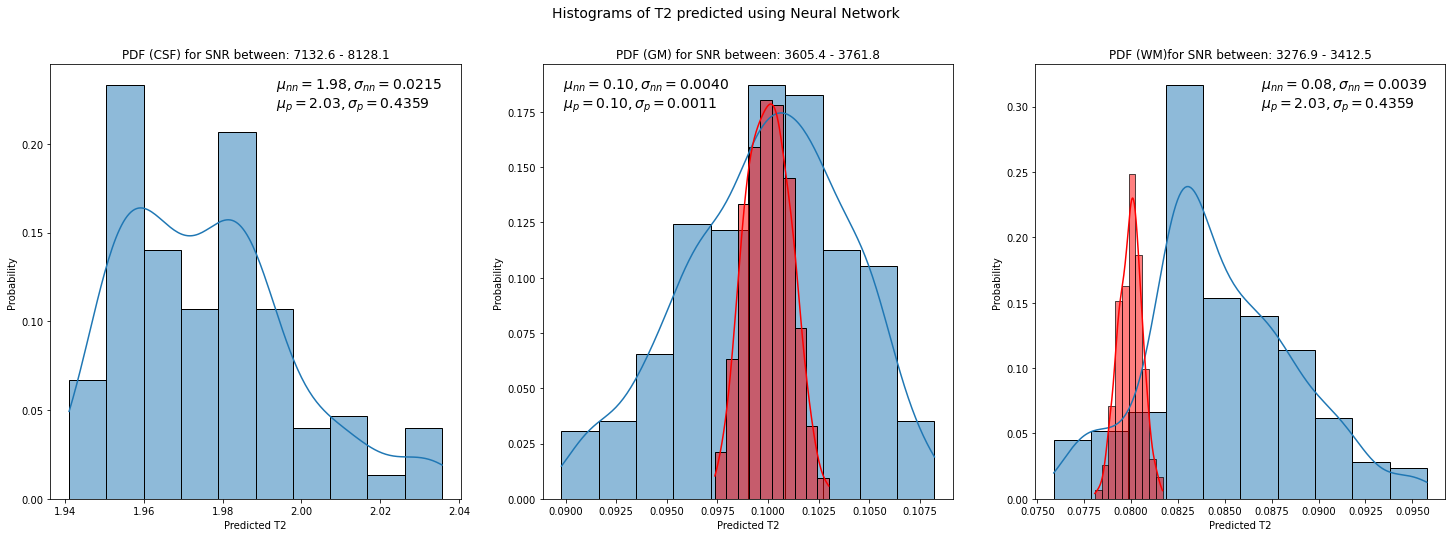

In [298]:
# Neural network : Monte Carlo
mean_csf_t2, std_csf_t2, csf_pdf = monte_carlo(new_csf_test) 
mean_gm_t2, std_gm_t2, gm_pdf = monte_carlo(new_gm_test)
mean_wm_t2, std_wm_t2, wm_pdf = monte_carlo(new_wm_test)

# Parameters for histograms plotting
snr_data = np.load('snr_data.npy')
s = '\n'
csf_str = s.join(['$\mu_{nn} = %.2f , \sigma_{nn}  = %.4f$'%(mean_csf_t2,std_csf_t2), '$\mu_{p}  = %.2f , \sigma_{p}  = %.4f$'%(mean_csf_t2_p,std_csf_t2_p)])
gm_str = s.join(['$\mu_{nn} = %.2f , \sigma_{nn} = %.4f$'%(mean_gm_t2,std_gm_t2), '$\mu_{p}  = %.2f , \sigma_{p}  = %.4f$'%(mean_gm_t2_p,std_gm_t2_p)])
wm_str = s.join(['$\mu_{nn} = %.2f , \sigma_{nn}  = %.4f$'%(mean_wm_t2,std_wm_t2), '$\mu_{p}  = %.2f , \sigma_{p}  = %.4f$'%(mean_csf_t2_p,std_csf_t2_p)])
textbox_height = 0.9
textbox_width  = 0.55
fs = 14
bins = 10

# Plotting of histograms
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 8))
fig.suptitle('Histograms of T2 predicted using Neural Network',fontsize=14)
# CSF 
# sns.histplot(data=csf_pdf, bins=bins, stat='probability', legend=False, kde=True, ax=ax1)
sns.histplot(data=csf_pdf, bins=bins, stat='probability', legend=False, kde=True, ax=ax1)
#sns.histplot(data=csf_pdf_p, bins=bins, stat='probability', legend=False, kde=True, color='r', ax=ax1)
ax1.set_title('PDF (CSF) for SNR between: %.1f - %.1f'%(snr_data[0],snr_data[1]))
ax1.text(textbox_width, textbox_height,csf_str,fontsize=fs,transform=ax1.transAxes)
ax1.set_xlabel('Predicted T2')
#ax1.set_xlim(min(csf_pdf),max(csf_pdf))
ax1.set_ylabel('Probability')

# GM
sns.histplot(data=gm_pdf, bins=bins, stat='probability', legend=False, kde=True, ax=ax2)
sns.histplot(data=gm_pdf_p, bins=bins, stat='probability', legend=False, kde=True, color='r', ax=ax2)
ax2.set_title('PDF (GM) for SNR between: %.1f - %.1f'%(snr_data[2],snr_data[3]))
ax2.text(textbox_width-0.5, textbox_height,gm_str,fontsize=fs,transform=ax2.transAxes)
ax2.set_xlabel('Predicted T2')
ax2.set_ylabel('Probability')

# WM
sns.histplot(data=wm_pdf, bins=bins, stat='probability', legend=False, kde=True, ax=ax3)
sns.histplot(data=wm_pdf_p, bins=bins, stat='probability', legend=False, kde=True, color='r', ax=ax3)
ax3.set_title('PDF (WM)for SNR between: %.1f - %.1f'%(snr_data[4],snr_data[5]))
ax3.text(textbox_width, textbox_height,wm_str,fontsize=fs,transform=ax3.transAxes)
ax3.set_xlabel('Predicted T2')
ax3.set_ylabel('Probability')

Text(0, 0.5, 'Probability')

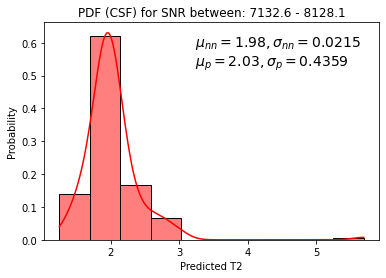

In [292]:
fig = plt.figure()
ax = fig.add_subplot(111)
sns.histplot(data=csf_pdf_p, bins=bins, stat='probability', legend=False, kde=True, color='r', ax=ax)
ax.set_title('PDF (CSF) for SNR between: %.1f - %.1f'%(snr_data[0],snr_data[1]))
ax.text(textbox_width-0.05, textbox_height-0.1,csf_str,fontsize=fs,transform=ax.transAxes)
ax.set_xlabel('Predicted T2')
#ax1.set_xlim(min(csf_pdf),max(csf_pdf))
ax.set_ylabel('Probability')